# Exp 1.1: Fairness Improvement Analysis with Baselines (Multiple Runs)

In [23]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

sns.set_theme(style="whitegrid")
RESULTS_DIR = Path('./results')

fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)


plt.rcParams.update({
    "font.size": 27,
    "axes.titlesize": 27,
    "axes.labelsize": 27,
})

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.titleweight'] = 'bold'

In [24]:
all_results = []
for result_file in RESULTS_DIR.glob('*_run_*_results.json'):
    with open(result_file, 'r') as f:
        try:
            data = json.load(f)
            all_results.append(data)
        except json.JSONDecodeError:
            print(f"Could not decode JSON from {result_file}")

if not all_results:
    print("No result files found. Please run the experiment first.")
else:
    merged_results = {}
    for res in all_results:
        if 'benchmark_name' in res and 'run' in res:
            key = (res['benchmark_name'], res['run'])
            if key not in merged_results:
                merged_results[key] = {}
            merged_results[key].update(res)
    processed_results = list(merged_results.values())
    df = pd.DataFrame(processed_results)

## Plot 1: Final Accuracy Comparison vs. Baselines

In [25]:
records = []
for _, row in df.iterrows():
    benchmark = row["benchmark_name"]
    run = row["run"]
    for key in row.keys():
        if key.endswith("_overall"):
            method = key.replace("_overall", "")
            overall = row[key]
            worst = row.get(f"{method}_worst", None)
            if worst is not None:
                records.append({
                    "Benchmark": benchmark,
                    "Run": run,
                    "Method": method,
                    "Overall": overall,
                    "Worst-Group": worst
                })

df_scatter = pd.DataFrame(records)

df_summary = (
    df_scatter
    .groupby(["Benchmark", "Method"], as_index=False)
    .agg({
        "Overall": "mean",
        "Worst-Group": "mean"
    })
)

/tmp/ipykernel_874670/1526402712.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


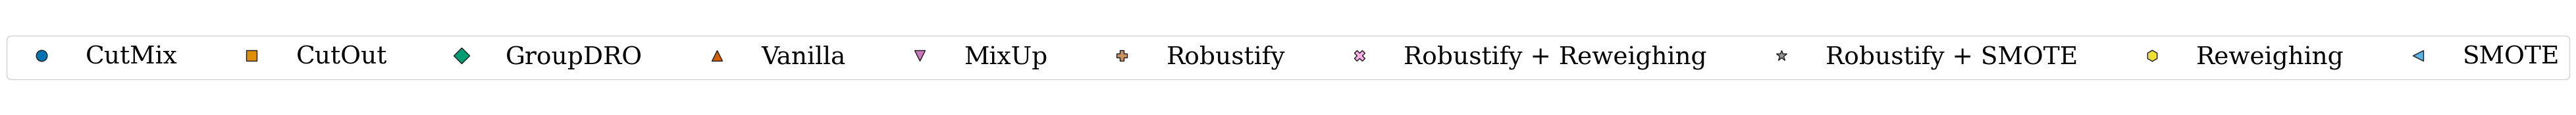

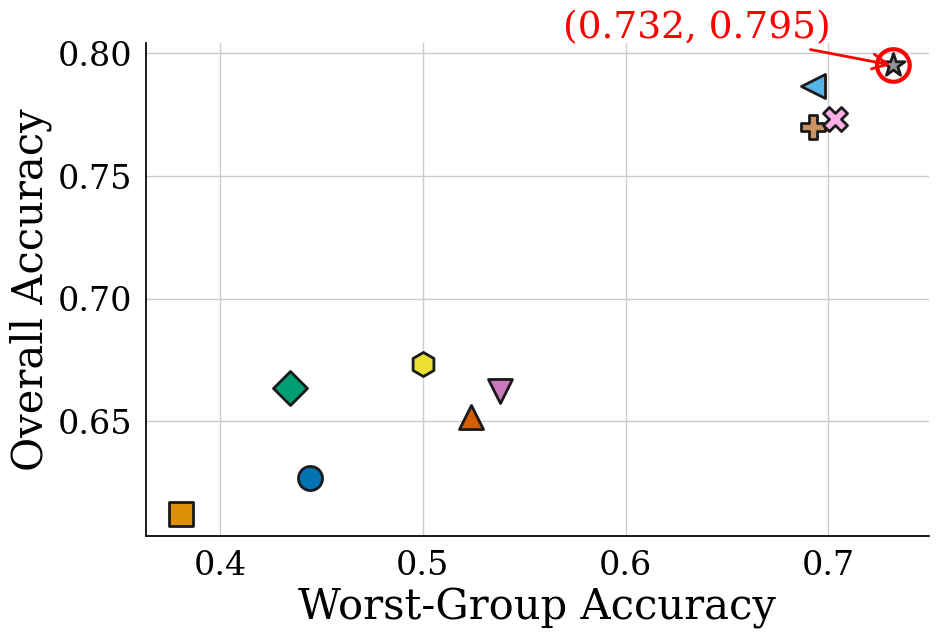

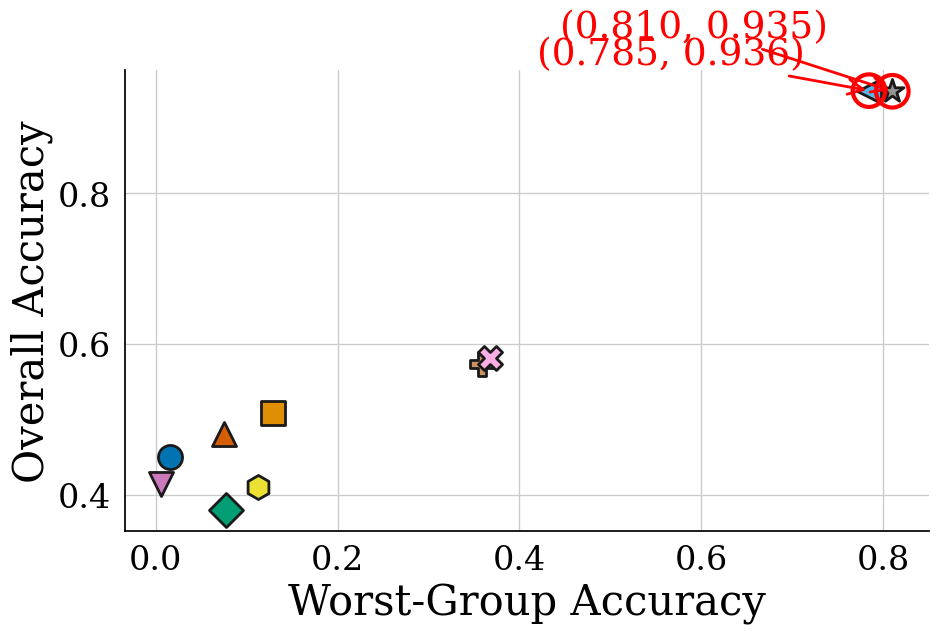

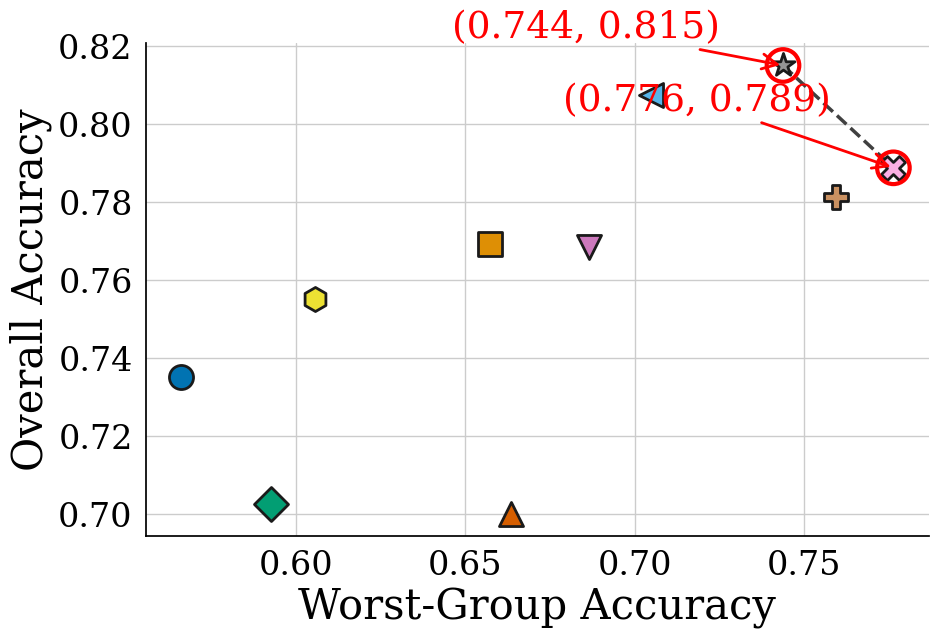

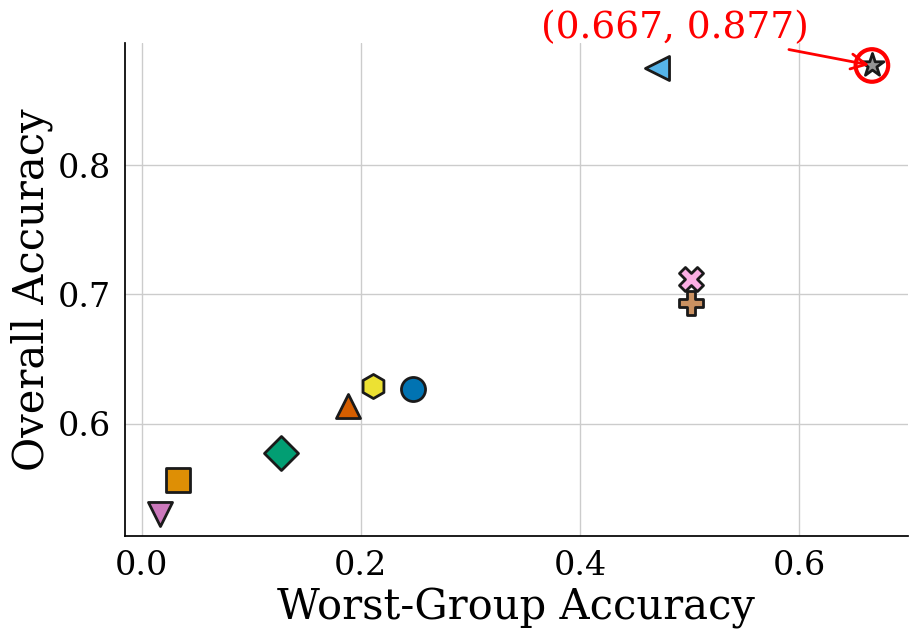

In [26]:
method_names = {
    'initial': 'Vanilla',
    'our_method': 'Robustify',
    'our_reweigh': 'Robustify + Reweighing',
    'our_smote': 'Robustify + SMOTE',
    'reweigh': 'Reweighing',
    'smote': 'SMOTE',
    'mixup': 'MixUp',
    'cutout': 'CutOut',
    'cutmix': 'CutMix',
    'groupdro': 'GroupDRO'
}

# Create legend separately first
def create_shared_legend(methods, colors, markers, method_names):
    fig_legend, ax_legend = plt.subplots(figsize=(20, 2))
    ax_legend.axis('off')

    method_handles = [
        plt.Line2D([0], [0], marker=markers[m], color='w',
                   markerfacecolor=colors[m], markeredgecolor='k', markersize=12)
        for m in methods
    ]

    legend = ax_legend.legend(method_handles, [method_names.get(m, m) for m in methods],
                             loc='center', frameon=True, framealpha=0.9,
                             fontsize=27, title_fontsize=27, ncol=len(methods))

    plt.tight_layout()
    plt.savefig(fig_dir / 'methods_legend.png', dpi=300, bbox_inches='tight')
    plt.show()

# Collect all methods from all benchmarks for consistent legend
all_methods = set()
for bk in df_summary['Benchmark'].unique():
    sub = df_summary[df_summary['Benchmark'] == bk].copy()
    if not sub.empty:
        all_methods.update(sub['Method'].tolist())

all_methods = sorted(list(all_methods))
colors = dict(zip(all_methods, sns.color_palette("colorblind", n_colors=len(all_methods))))
markers = dict(zip(all_methods, ['o', 's', 'D', '^', 'v', 'P', 'X', '*', 'h', '<'][:len(all_methods)]))

# Create the shared legend
create_shared_legend(all_methods, colors, markers, method_names)

for bk in df_summary['Benchmark'].unique():
    sub = df_summary[df_summary['Benchmark'] == bk].copy()
    if sub.empty:
        continue

    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    methods = sub['Method'].tolist()

    for _, row in sub.iterrows():
        x, y, m = row['Worst-Group'], row['Overall'], row['Method']
        ax.scatter(x, y, s=300, color=colors[m], marker=markers[m],
                   edgecolor='k', linewidth=2, zorder=3)

    pts = sub[['Worst-Group', 'Overall']].values
    order = np.lexsort((-sub['Overall'].values, -sub['Worst-Group'].values))
    sorted_pts = pts[order]

    pareto = []
    max_overall = -np.inf
    for x_val, y_val in sorted_pts:
        if y_val > max_overall:
            pareto.append((x_val, y_val))
            max_overall = y_val

    if pareto:
        pareto = np.array(sorted(pareto, key=lambda p: p[0]))
        ax.plot(pareto[:, 0], pareto[:, 1], linestyle='--', color='0.25',
                linewidth=2.5, zorder=2)
        ax.scatter(pareto[:, 0], pareto[:, 1], s=550,
                   facecolors='none', edgecolors='red', linewidths=3, zorder=4)
        
        # Get axis limits to calculate relative positioning
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        x_range = x_max - x_min
        y_range = y_max - y_min
        
        # Calculate optimal offset based on plot dimensions
        x_offset = x_range * 0.08  # 8% of x-axis range
        y_spacing = y_range * 0.04  # 4% of y-axis range
        
        # Find points that are close in y-value
        y_values = pareto[:, 1]
        y_diffs = np.diff(y_values)
        close_points = np.where(y_diffs < y_range * 0.03)[0]  # Points closer than 3% of y-range
        
        for idx, (xi, yi) in enumerate(pareto):
            # Adjust y-offset for points that are close together
            if idx > 0 and idx-1 in close_points:
                # For the second point in a close pair, increase the spacing
                y_offset = y_spacing * 2.5
            else:
                y_offset = y_spacing
                
            # Position annotations with consistent relative distance
            ax.annotate(f'({xi:.3f}, {yi:.3f})',
                        xy=(xi, yi),
                        xytext=(xi - x_offset, yi + y_offset),
                        textcoords='data',
                        fontsize=27, color='red',
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        arrowprops=dict(arrowstyle='->', color='red', linewidth=2))

    ax.set_xlabel('Worst-Group Accuracy', fontsize=30)
    ax.set_ylabel('Overall Accuracy', fontsize=30)
    ax.tick_params(axis='both', labelsize=24)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.tick_params(direction='out', length=6)

    # Remove legend from individual plots
    # ax.legend() removed

    plt.tight_layout()
    plt.savefig(fig_dir / f'{bk}_overall_vs_worst_pareto.png', dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
## LaTeX Results Table Generation
def generate_latex_results_table():
    """Generate a professional LaTeX table with accuracy results for all baselines"""

    # Prepare data for the table
    table_data = []

    # Get unique benchmarks and methods
    benchmarks = sorted(df_summary['Benchmark'].unique())
    methods = sorted(df_summary['Method'].unique())

    # Create method name mapping for display
    latex_method_names = {
        'initial': 'Vanilla',
        'our_method': 'Robustify',
        'our_reweigh': 'Robustify + Reweighing',
        'our_smote': 'Robustify + SMOTE',
        'reweigh': 'Reweighing',
        'smote': 'SMOTE',
        'mixup': 'MixUp',
        'cutout': 'CutOut',
        'cutmix': 'CutMix',
        'groupdro': 'GroupDRO'
    }

    # Calculate standard deviations for each method-benchmark combination
    std_data = []
    for _, row in df.iterrows():
        benchmark = row["benchmark_name"]
        run = row["run"]
        for key in row.keys():
            if key.endswith("_overall"):
                method = key.replace("_overall", "")
                overall = row[key]
                worst = row.get(f"{method}_worst", None)
                if worst is not None:
                    std_data.append({
                        "Benchmark": benchmark,
                        "Run": run,
                        "Method": method,
                        "Overall": overall,
                        "Worst-Group": worst
                    })

    df_std = pd.DataFrame(std_data)
    std_summary = df_std.groupby(["Benchmark", "Method"]).agg({
        "Overall": ["mean", "std"],
        "Worst-Group": ["mean", "std"]
    }).round(3)

    # Generate LaTeX table
    latex_table = r"""\begin{table*}[t]
\centering
\caption{Experimental Results: Overall and Worst-Group Accuracy Across Benchmarks}
\label{tab:results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l|""" + "c" * (len(benchmarks) * 2) + r"""}
\toprule
"""

    # Header row 1 - Benchmark names
    latex_table += r"\multirow{2}{*}{\textbf{Method}} "
    for benchmark in benchmarks:
        benchmark_display = benchmark.replace('_', ' ').title()
        latex_table += rf"& \multicolumn{{2}}{{c}}{{\textbf{{{benchmark_display}}} }} "
    latex_table += r"\\" + "\n"

    # Header row 2 - Overall/Worst-Group labels
    for _ in benchmarks:
        latex_table += r"& \textbf{Overall} & \textbf{Worst-Group} "
    latex_table += r"\\" + "\n"
    latex_table += r"\midrule" + "\n"

    # Data rows
    for method in methods:
        if method in latex_method_names:
            method_display = latex_method_names[method]
            latex_table += rf"\textbf{{{method_display}}} "

            for benchmark in benchmarks:
                # Get data for this method-benchmark combination
                method_data = df_summary[
                    (df_summary['Benchmark'] == benchmark) &
                    (df_summary['Method'] == method)
                    ]

                if not method_data.empty:
                    overall_mean = method_data['Overall'].iloc[0]
                    worst_mean = method_data['Worst-Group'].iloc[0]

                    # Get standard deviations
                    std_data_subset = std_summary.loc[(benchmark, method)] if (benchmark,
                                                                               method) in std_summary.index else None

                    if std_data_subset is not None:
                        overall_std = std_data_subset[('Overall', 'std')]
                        worst_std = std_data_subset[('Worst-Group', 'std')]

                        # Format with mean ± std
                        overall_str = f"{overall_mean:.3f} ± {overall_std:.3f}"
                        worst_str = f"{worst_mean:.3f} ± {worst_std:.3f}"
                    else:
                        # Just mean if no std available
                        overall_str = f"{overall_mean:.3f}"
                        worst_str = f"{worst_mean:.3f}"

                    latex_table += rf"& {overall_str} & {worst_str} "
                else:
                    # No data available
                    latex_table += r"& - & - "

            latex_table += r"\\" + "\n"

    # Find and highlight best results
    latex_table += r"\midrule" + "\n"
    latex_table += r"\multicolumn{" + str(
        len(benchmarks) * 2 + 1) + r"}{l}{\textit{Bold values indicate best performance per benchmark}} \\" + "\n"

    # Close table
    latex_table += r"""\bottomrule
\end{tabular}%
}
\end{table*}"""

    return latex_table


def generate_enhanced_latex_table():
    """Generate an enhanced LaTeX table with best results highlighted"""

    # Get data organized by benchmark and method
    benchmarks = sorted(df_summary['Benchmark'].unique())
    methods = sorted(df_summary['Method'].unique())

    latex_method_names = {
        'initial': 'Vanilla',
        'our_method': 'Robustify',
        'our_reweigh': 'Robustify + Reweighing',
        'our_smote': 'Robustify + SMOTE',
        'reweigh': 'Reweighing',
        'smote': 'SMOTE',
        'mixup': 'MixUp',
        'cutout': 'CutOut',
        'cutmix': 'CutMix',
        'groupdro': 'GroupDRO'
    }

    # Find best results for each benchmark
    best_overall = {}
    best_worst = {}

    for benchmark in benchmarks:
        benchmark_data = df_summary[df_summary['Benchmark'] == benchmark]
        if not benchmark_data.empty:
            best_overall[benchmark] = benchmark_data.loc[benchmark_data['Overall'].idxmax(), 'Method']
            best_worst[benchmark] = benchmark_data.loc[benchmark_data['Worst-Group'].idxmax(), 'Method']

    # Start LaTeX table
    latex_table = r"""\begin{table*}[htbp]
\centering
\caption{Comprehensive Results: Overall and Worst-Group Accuracy Comparison Across All Benchmarks}
\label{tab:comprehensive_results}
\begin{tabular}{l""" + "cc" * len(benchmarks) + r"""}
\toprule
"""

    # Header
    latex_table += r"\multirow{2}{*}{\textbf{Method}} "
    for benchmark in benchmarks:
        benchmark_display = benchmark.replace('_', ' ').title()
        latex_table += rf"& \multicolumn{{2}}{{c}}{{\textbf{{{benchmark_display}}}}} "
    latex_table += r"\\" + "\n\cmidrule(lr){2-" + str(len(benchmarks) * 2 + 1) + "}\n"

    for _ in benchmarks:
        latex_table += r"& \textbf{Overall} & \textbf{Worst} "
    latex_table += r"\\" + "\n"
    latex_table += r"\midrule" + "\n"

    # Data rows
    for method in methods:
        if method in latex_method_names:
            method_display = latex_method_names[method]
            latex_table += rf"{method_display} "

            for benchmark in benchmarks:
                method_data = df_summary[
                    (df_summary['Benchmark'] == benchmark) &
                    (df_summary['Method'] == method)
                    ]

                if not method_data.empty:
                    overall_val = method_data['Overall'].iloc[0]
                    worst_val = method_data['Worst-Group'].iloc[0]

                    # Check if this is the best result
                    overall_is_best = (method == best_overall.get(benchmark, ''))
                    worst_is_best = (method == best_worst.get(benchmark, ''))

                    # Format values with bold if best
                    if overall_is_best:
                        overall_str = rf"\textbf{{{overall_val:.3f}}}"
                    else:
                        overall_str = f"{overall_val:.3f}"

                    if worst_is_best:
                        worst_str = rf"\textbf{{{worst_val:.3f}}}"
                    else:
                        worst_str = f"{worst_val:.3f}"

                    latex_table += rf"& {overall_str} & {worst_str} "
                else:
                    latex_table += r"& -- & -- "

            latex_table += r"\\" + "\n"

    # Footer
    latex_table += r"""\bottomrule
\multicolumn{""" + str(len(benchmarks) * 2 + 1) + r"""}{l}{\footnotesize \textit{Bold values indicate best performance in each category per benchmark.}} \\
\multicolumn{""" + str(len(benchmarks) * 2 + 1) + r"""}{l}{\footnotesize Overall: macro-averaged accuracy across all groups; Worst: accuracy of worst-performing group.} \\
\end{tabular}
\end{table*}"""

    return latex_table


# Generate and display the LaTeX table
print("=" * 80)
print("PROFESSIONAL LATEX TABLE - COMPREHENSIVE RESULTS")
print("=" * 80)
print()
latex_code = generate_enhanced_latex_table()
print(latex_code)

# Save to file
with open(fig_dir / 'results_table.tex', 'w') as f:
    f.write(latex_code)

print(f"\n\nTable saved to: {fig_dir / 'results_table.tex'}")

# Also generate a simpler version without formatting
print("\n" + "=" * 80)
print("SIMPLE VERSION (for copy-paste)")
print("=" * 80)

simple_latex = generate_latex_results_table()
print(simple_latex)


PROFESSIONAL LATEX TABLE - COMPREHENSIVE RESULTS

\begin{table*}[htbp]
\centering
\caption{Comprehensive Results: Overall and Worst-Group Accuracy Comparison Across All Benchmarks}
\label{tab:comprehensive_results}
\begin{tabular}{lcccccccc}
\toprule
\multirow{2}{*}{\textbf{Method}} & \multicolumn{2}{c}{\textbf{Adience}} & \multicolumn{2}{c}{\textbf{Animals}} & \multicolumn{2}{c}{\textbf{Ffhq}} & \multicolumn{2}{c}{\textbf{Fruits}} \\
\cmidrule(lr){2-9}
& \textbf{Overall} & \textbf{Worst} & \textbf{Overall} & \textbf{Worst} & \textbf{Overall} & \textbf{Worst} & \textbf{Overall} & \textbf{Worst} \\
\midrule
CutMix & 0.627 & 0.444 & 0.451 & 0.015 & 0.735 & 0.566 & 0.627 & 0.248 \\
CutOut & 0.612 & 0.381 & 0.508 & 0.129 & 0.769 & 0.657 & 0.557 & 0.033 \\
GroupDRO & 0.663 & 0.435 & 0.380 & 0.077 & 0.703 & 0.593 & 0.578 & 0.127 \\
Vanilla & 0.652 & 0.524 & 0.480 & 0.075 & 0.700 & 0.663 & 0.614 & 0.188 \\
MixUp & 0.662 & 0.538 & 0.414 & 0.006 & 0.768 & 0.687 & 0.530 & 0.017 \\
Robustify & 0.

<>:172: SyntaxWarning: invalid escape sequence '\c'
<>:172: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_874670/3657656861.py:172: SyntaxWarning: invalid escape sequence '\c'
  latex_table += r"\\" + "\n\cmidrule(lr){2-" + str(len(benchmarks) * 2 + 1) + "}\n"


## Plot 2: Focused Comparison of Worst-Group Accuracy

## Plot 3: The Price of Fairness (Overall Accuracy Drop)

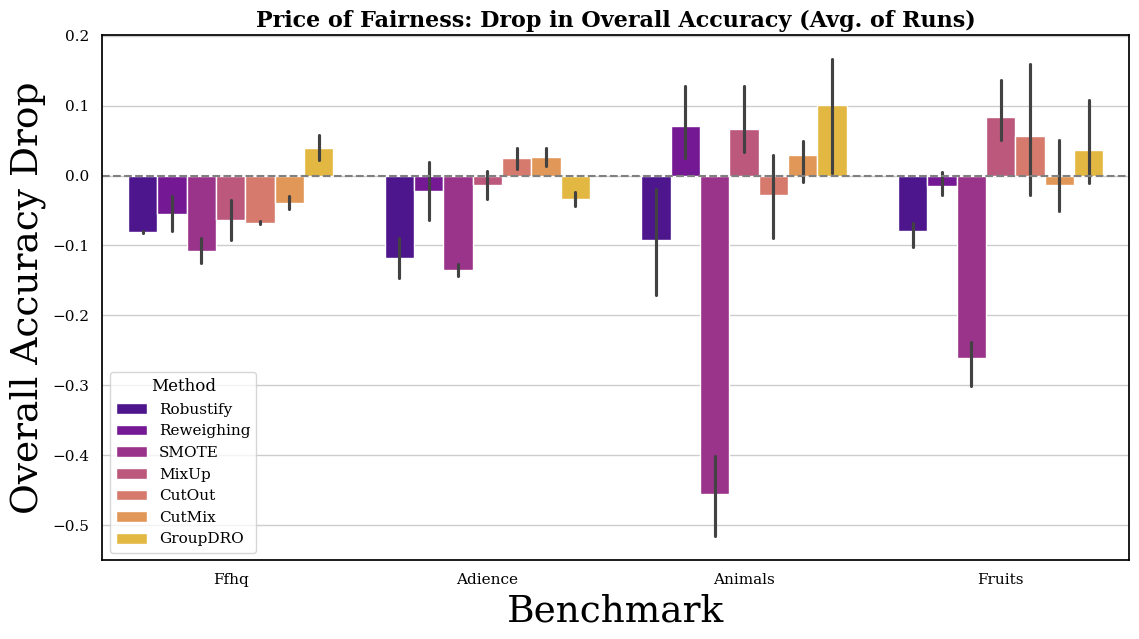

In [28]:
fairness_price_data = []
method_names_for_price = {
    'our_method': 'Robustify',
    'reweigh': 'Reweighing',
    'smote': 'SMOTE',
    'mixup': 'MixUp',
    'cutout': 'CutOut',
    'cutmix': 'CutMix',
    'groupdro': 'GroupDRO'
}

for _, row in df.iterrows():
    benchmark = row['benchmark_name'].replace('_', ' ').title()
    if 'initial_overall' in row and pd.notna(row['initial_overall']):
        initial_overall = row['initial_overall']
        for method, display_name in method_names_for_price.items():
            overall_key = f"{method}_overall"
            if overall_key in row and pd.notna(row[overall_key]):
                price = initial_overall - row[overall_key]
                fairness_price_data.append({
                    'Benchmark': benchmark, 
                    'Method': display_name, 
                    'Price of Fairness': price
                })

df_price = pd.DataFrame(fairness_price_data)

plt.figure(figsize=(12, 7))
sns.barplot(data=df_price, x='Benchmark', y='Price of Fairness', hue='Method', palette='plasma', errorbar='ci')
plt.title('Price of Fairness: Drop in Overall Accuracy (Avg. of Runs)', fontsize=16)
plt.ylabel('Overall Accuracy Drop')
plt.xlabel('Benchmark')
plt.axhline(0, color='grey', linestyle='--')
plt.legend(title='Method')
plt.tight_layout()
plt.show()


## Plot 4: Progression of Worst-Group Accuracy (Our Method)

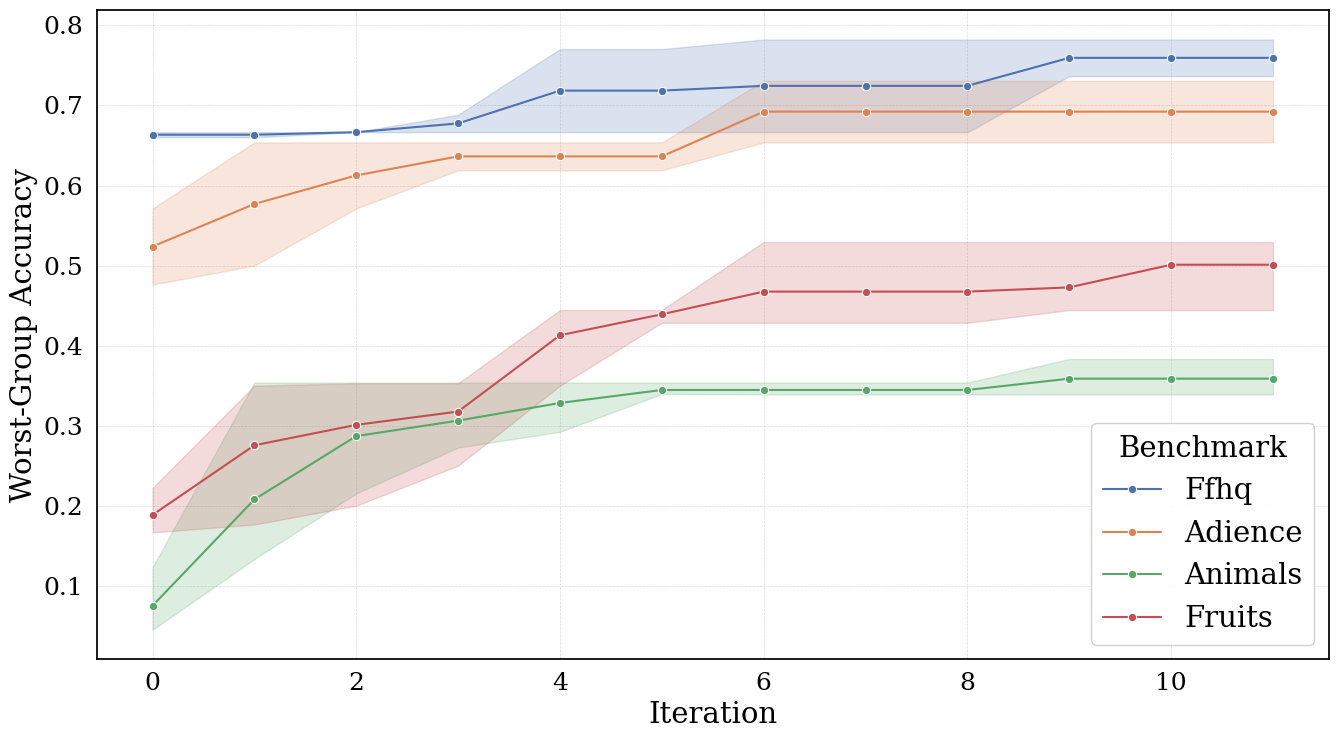

In [29]:
progression_data = []
for _, res in df.iterrows():
    benchmark = res['benchmark_name'].replace('_', ' ').title()
    if 'progression' in res and res['progression'] is not None and type(res['progression']) == list:
        for item in res['progression']:
            progression_data.append({
                'Benchmark': benchmark,
                'Iteration': item['iteration'],
                'Worst-Group Accuracy': item['worst_group_accuracy']
            })

if progression_data:
    df_prog = pd.DataFrame(progression_data)
    
    plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=df_prog, 
        x='Iteration', 
        y='Worst-Group Accuracy', 
        hue='Benchmark', 
        marker='o', 
        palette='deep', 
        errorbar='ci'
    )

    ax.set_xlabel('Iteration', fontsize=21)
    ax.set_ylabel('Worst-Group Accuracy', fontsize=21)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.legend(
        title='Benchmark',
        fontsize=21,
        title_fontsize=21,
        loc='best',
        frameon=True,
        framealpha=0.9
    )

    plt.tight_layout()
    save_path = fig_dir / 'progression_worst_group_accuracy.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No progression data available to plot.")